In [1]:
import sys
import datetime

import numpy as np
from scipy import integrate
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from struct import pack, unpack

sys.path.insert(0, "../")
from paths import FIG_DIR, DATA_DIR

In [11]:
def initialize_symmetric_tournament(m):
    if m % 2 != 1:
        raise ValueError("The value of m is even, please choose an odd value.")
    ssb = np.zeros((m, m))
    for k in range(1, int((m+1)/2)):
        for i in range(m):
            ssb[i, (i+k)%m] = 1
            ssb[i, (i-k)%m] = -1
    return ssb

In [ ]:
# intr_dict = {3: 0.24521831109433967, 5: 0.2486390358113208} # compare Notebook 5_1 and 5_3
# with open(DATA_DIR / '5_5_sim_symmetric.dat', 'wb') as file:
#     file.write(pack('d' * len(intr_dict) , *intr_dict.values()))

In [3]:
num_samples = 2.65 * 10**10 #1 sample corresponds to 3 lotteries, a triple!

with open(DATA_DIR / '5_5_sim_symmetric.dat', 'rb') as file:
    packed = file.read()
    read = list(unpack('d' * (len(packed) // 8), packed)) # 8 bytes per double
intr_dict = {2*i + 3: read[i] for i in range(len(read))}

for m in range(3 + 2*len(intr_dict), 16, 2):
    now = datetime.datetime.now()
    print(f"Starting {m} at {now.strftime('%Y-%m-%d %H:%M:%S')}")

    rng = np.random.default_rng(2025 + m)
    ssb_intr = initialize_symmetric_tournament(m)
    alpha = np.ones(m)
    batch_size = 10**7

    batch_results = []

    for i in range(len(batch_results)*batch_size, int(num_samples), batch_size):
        lotteries = rng.dirichlet(alpha, (3, batch_size))
        comp01 = (np.sum(lotteries[0,:,:] @ ssb_intr * lotteries[1,:,:], axis=1) > 0).astype(int)
        comp12 = (np.sum(lotteries[1,:,:] @ ssb_intr * lotteries[2,:,:], axis=1) > 0).astype(int)
        comp20 = (np.sum(lotteries[2,:,:] @ ssb_intr * lotteries[0,:,:], axis=1) > 0).astype(int)
        num_intr = np.sum(comp01 + comp12 + comp20 == 0) + np.sum(comp01 + comp12 + comp20 == 3)
        batch_results.append(num_intr/batch_size)

    now = datetime.datetime.now()
    print(f"Finished {m} at {now.strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Results for m={m}: np.mean(batch_results)={np.mean(batch_results)}, np.std(batch_results)={np.std(batch_results)}, len(batch_results)={len(batch_results)}")
    intr_dict[m] = np.mean(batch_results)
    with open(DATA_DIR / '5_5_sim_symmetric.dat', 'wb') as file:
        file.write(pack('d' * len(intr_dict) , *intr_dict.values()))

Starting 13 at 2025-05-01 09:13:43
Finished 13 at 2025-05-01 13:29:23
Results for m=13: np.mean(batch_results)=0.24991388441509432, np.std(batch_results)=0.0001395371210316091, len(batch_results)=2650
Starting 15 at 2025-05-01 13:29:23
Finished 15 at 2025-05-01 18:14:58
Results for m=15: np.mean(batch_results)=0.24994523573584904, np.std(batch_results)=0.0001358840464983305, len(batch_results)=2650


In [2]:
with open(DATA_DIR / '5_5_sim_symmetric.dat', 'rb') as file:
    packed = file.read()
    read = list(unpack('d' * (len(packed) // 8), packed)) # 8 bytes per double
intr_dict = {2*i + 3: read[i] for i in range(len(read))}
intr_dict

{3: 0.24521831109433967,
 5: 0.2486390358113208,
 7: 0.24946034226415095,
 9: 0.2497422017735849,
 11: 0.24985942950943396,
 13: 0.24991388441509432,
 15: 0.24994523573584904}

In [3]:
df = pd.DataFrame(intr_dict.items(), columns=["num_alt", "prob_intr"])
df['error'] = 1e-5
df.loc[df['num_alt'] == 3, 'prob_intr'] = (6 + 20*np.log(2)) / 3**4
df

,num_alt,prob_intr,error
0,3,0.245222,0.00001
1,5,0.248639,0.00001
2,7,0.249460,0.00001
3,9,0.249742,0.00001
4,11,0.249859,0.00001
5,13,0.249914,0.00001
6,15,0.249945,0.00001


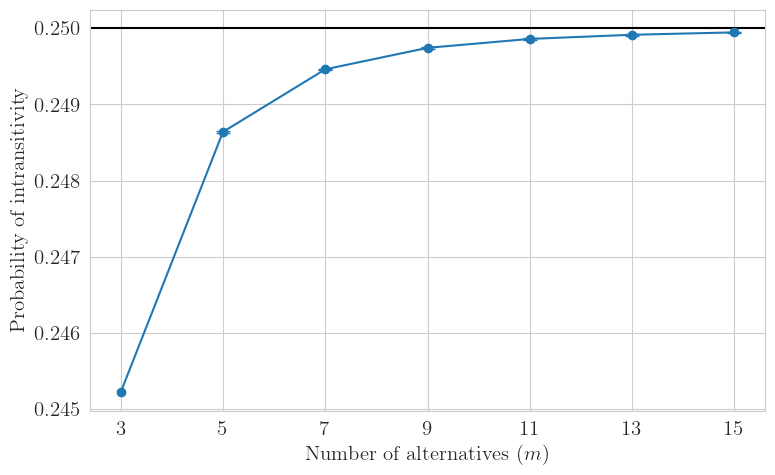

In [4]:
sns.set_style("whitegrid")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cm'
mpl.rcParams['font.size'] = 15

# Plot with error bars
plt.figure(figsize=(8, 5))
line = sns.lineplot(x='num_alt', y='prob_intr', data=df, err_style='bars', errorbar=None)
plt.errorbar(df[df['num_alt'] > 3]['num_alt'], df[df['num_alt'] > 3]['prob_intr'], yerr=df[df['num_alt'] > 3]['error'], fmt='o', color=line.lines[0].get_color(), capsize=5)
plt.axhline(y=0.25, color='black')
plt.scatter(3, (6 + 20*np.log(2)) / 3**4, color=line.lines[0].get_color())

# Set x-axis ticks to show only odd numbers
plt.xticks(ticks=df['num_alt'][df['num_alt'] % 2 == 1])

# Modify axis labels
plt.xlabel(r'Number of alternatives ($m$)')
plt.ylabel("Probability of intransitivity")

plt.tight_layout()
plt.savefig(FIG_DIR / "5_5_sim_intr_low_m.png", dpi=300)
plt.savefig(FIG_DIR / "5_5_sim_intr_low_m.pdf")

In [31]:
import numpy as np

num_rep = 10**5  # executed 10 times
rng = np.random.default_rng(5302)
results = {}

for m in [5, 15, 25, 35, 51, 71, 101, 151, 201, 301, 401, 601, 801, 1001]:
    results[m] = []
    ssb_utility = initialize_symmetric_tournament(m)
    alpha = np.ones(m)
    for _ in range(10):
        lotteries = rng.dirichlet(alpha, (3, num_rep))
        comp01 = (np.sum(lotteries[0,:,:] @ ssb_utility * lotteries[1,:,:], axis=1) > 0).astype(int)
        comp12 = (np.sum(lotteries[1,:,:] @ ssb_utility * lotteries[2,:,:], axis=1) > 0).astype(int)
        comp20 = (np.sum(lotteries[2,:,:] @ ssb_utility * lotteries[0,:,:], axis=1) > 0).astype(int)
        num_intr = np.sum(comp01 + comp12 + comp20 == 0) + np.sum(comp01 + comp12 + comp20 == 3)
        results[m].append(num_intr)
    print(f"Completed m = {m}")

Completed m = 5
Completed m = 15
Completed m = 25
Completed m = 35
Completed m = 51
Completed m = 71
Completed m = 101
Completed m = 151
Completed m = 201
Completed m = 301
Completed m = 401
Completed m = 601
Completed m = 801
Completed m = 1001


In [32]:
import pickle 

with open(DATA_DIR / '5_5_sim_intr_large_m.pkl', 'wb') as f:
    pickle.dump(results, f)
        
with open(DATA_DIR / '5_5_sim_intr_large_m.pkl', 'rb') as f:
    results = pickle.load(f)

results

{5: [25096, 24871, 24765, 24943, 24939, 25103, 25017, 24854, 24806, 24537],
 15: [25094, 25122, 24755, 24844, 24913, 24822, 25179, 25077, 25185, 25044],
 25: [24881, 25080, 25108, 24965, 25218, 24873, 25095, 24823, 24806, 24884],
 35: [24989, 24938, 24832, 24782, 25102, 24983, 25019, 24996, 24937, 25042],
 51: [25092, 24939, 24859, 25112, 24955, 25118, 24962, 24898, 24914, 24781],
 71: [24888, 24913, 25023, 24920, 25213, 24936, 24979, 24942, 25161, 25151],
 101: [25064, 25059, 24769, 25067, 24922, 25056, 24696, 25102, 24905, 24612],
 151: [25051, 24849, 25024, 24683, 25066, 24916, 24973, 24895, 25044, 24869],
 201: [24817, 25006, 24987, 24814, 25000, 25245, 25029, 24981, 24795, 25350],
 301: [25097, 25207, 24819, 25114, 24991, 25124, 24903, 24745, 24933, 25082],
 401: [24794, 25021, 25071, 25011, 24914, 24920, 25034, 25083, 25121, 24954],
 601: [25108, 24968, 25086, 24989, 24827, 25152, 24945, 24968, 24979, 25273],
 801: [24759, 25137, 24904, 24874, 25121, 25140, 25044, 24914, 25184, 2

In [33]:
plotting_dict = {}

for key, value in results.items():
    plotting_dict[key] = np.mean(value) / num_rep

df = pd.DataFrame(plotting_dict.items(), columns=["num_alt", "prob_intr"])
df

,num_alt,prob_intr
0,5,0.248931
1,15,0.250035
2,25,0.249733
3,35,0.249620
4,51,0.249630
5,71,0.250126
6,101,0.249252
7,151,0.249370
8,201,0.250024
9,301,0.250015


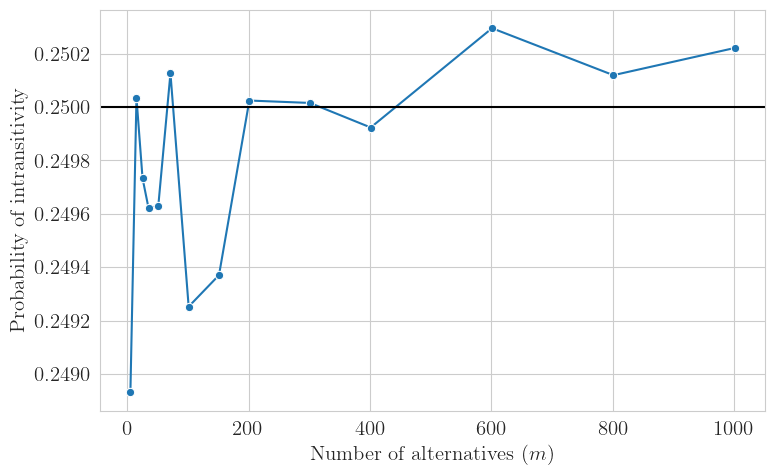

In [35]:
sns.set_style(style="whitegrid")
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'cm'
mpl.rcParams['font.size'] = 15

# Plot with error bars
plt.figure(figsize=(8, 5))
line = sns.lineplot(x='num_alt', y='prob_intr', data=df, err_style='bars', errorbar=None, marker='o')
plt.axhline(y=0.25, color='black')

# Modify axis labels
plt.xlabel(r'Number of alternatives ($m$)')
plt.ylabel("Probability of intransitivity")

plt.tight_layout()
plt.savefig(FIG_DIR / "5_5_sim_intr_high_m.png", dpi=300)
plt.savefig(FIG_DIR / "5_5_sim_intr_high_m.pdf")